## Neural network detector training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path, getcwd
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.augment.util import amplitudes
from yass.geometry import make_channel_index
from yass.augment.util import amplitudes

import numpy as np
from scipy.io import loadmat

from dstools import plot
from dstools.reproducibility import make_filename
from dstools.reproducibility.util import get_version, git_hash_in_path
from dstools.util import save

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [3]:
# for reference
here = getcwd()
here_version = git_hash_in_path(here)
print('YASS version is: {}'.format(util.get_version()))
print('nbs version is: {}'.format(here_version))

YASS version is: 2534dbd fix
nbs version is: 924b9c1 generating detect training set with hard cases and hard cases removed


In [4]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [5]:
yass.set_config("../../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Load training data

In [6]:
TRAINING_SET_NAME = 'training-set-hard-cases-present.npz'
path_to_output = Path(path_to_data, 'detect', TRAINING_SET_NAME)
data = np.load(path_to_output)

X = data['X']
y = data['y']

In [7]:
positive = X[y == 1]
amps = amplitudes(positive)
idx_sorted = np.argsort(amps)
print('Positive examples min amp: {}, Mas amp: {}'.format(amps.min(), amps.max()))

Positive examples min amp: 2.6382242049396383, Mas amp: 62.95888100136638


## Visualizing training set

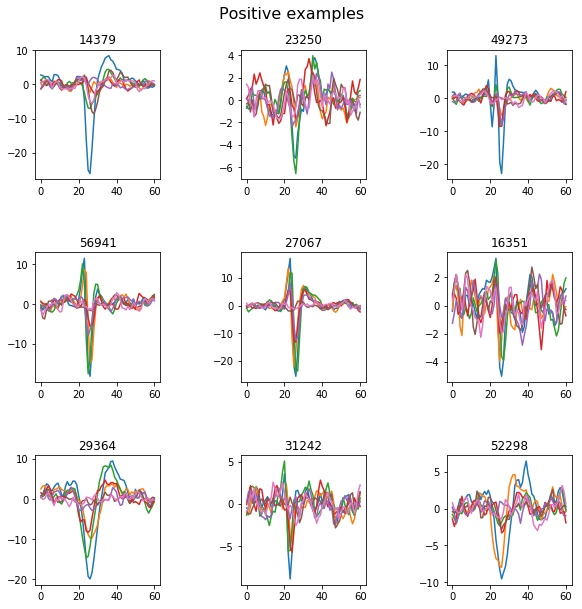

In [8]:
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9,
                     auto_figsize=3)

_ = plt.suptitle('Positive examples', fontsize=16)
_ = plt.tight_layout(pad=4)

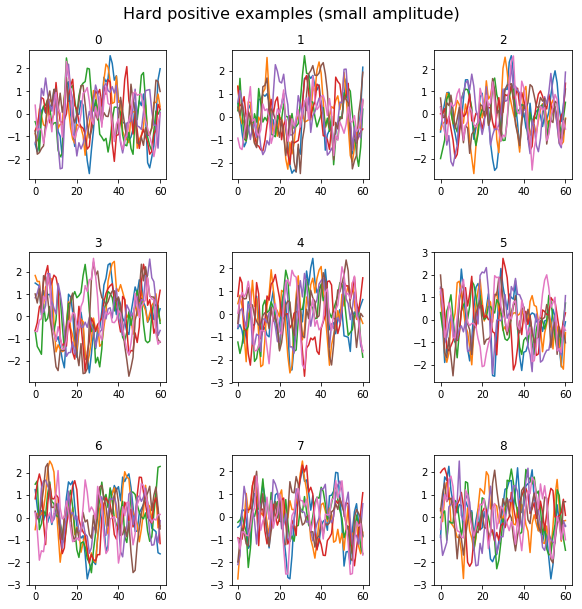

In [9]:
plot.grid_from_array(positive[idx_sorted], axis=0,
                     elements=range(9),
                     auto_figsize=3)

_ = plt.suptitle('Hard positive examples (small amplitude)', fontsize=16)
_ = plt.tight_layout(pad=4)

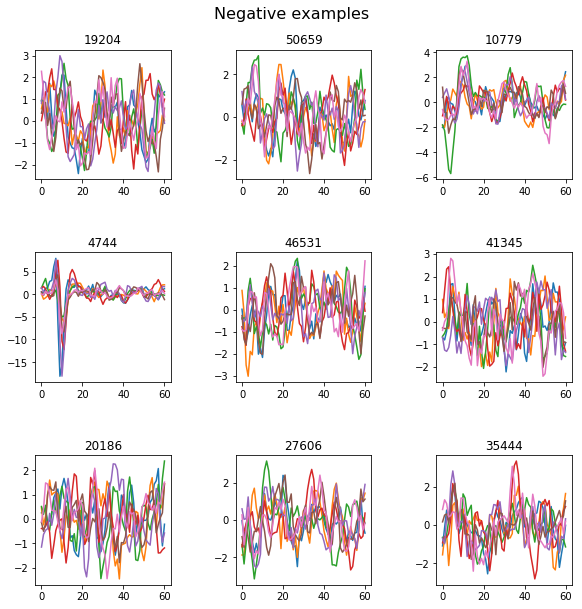

In [10]:
plot.grid_from_array(X[y== 0], axis=0,
                     elements=9,
                     auto_figsize=3)

_ = plt.suptitle('Negative examples', fontsize=16)
_ = plt.tight_layout(pad=4)

# Training

In [11]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.0001
filters_detect = [32, 32]

path_to_models = path.join(path_to_data, 'detect', 'models')

## Detector training

In [12]:
from os import path
from dstools.reproducibility import make_filename

detect_name = path.join(path_to_models,
                        make_filename(extension='ckpt'))

print('Training {}...'.format(detect_name))

_, waveform_length, n_neighbors =  X.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(X, y, save_test_set=True)

Training /home/Edu/data/detect/models/2018-10-04T17-37-32.ckpt...


Tr loss: 0.0015870366, Val loss: 0.013168159: 100%|██████████| 5000/5000 [00:36<00:00, 137.55it/s] 


{'filters_size': [32, 32],
 'waveform_length': 61,
 'n_neighbors': 7,
 'name': '2018-10-04T17-37-32',
 'tn': 0.9971082261736295,
 'fp': 0.002181278136167448,
 'fn': 0.005106749523164954,
 'tp': 0.9961479556318745,
 'acc': 0.9965608465608465,
 'prec': 0.9978150713588396,
 'rec': 0.9961479556318745,
 'metadata': {'yass_version': '2534dbd fix'}}